# Training a Model for Temperature Forecasting 

## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset. But sequence data is found in many more problems than just language processing. We will be playing with a weather 
timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: (Download) http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded 
every ten minutes, over several years. 

This dataset is perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a few days worth of data points) and predicts the air temperature 24 hours in the future.


Let's take a look at the data:

In [1]:
import os

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [2]:
print('Columns in the file', end=" ")
print(header)

print('\n\nTotal number of records', end=" ")
print(len(lines))

Columns in the file ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


Total number of records 420551


Let's convert all of these 420,551 lines of data into a Numpy array:

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

For instance, here is the plot of temperature (in degrees Celsius) over time:

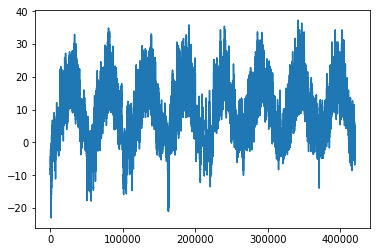

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points 
per day):

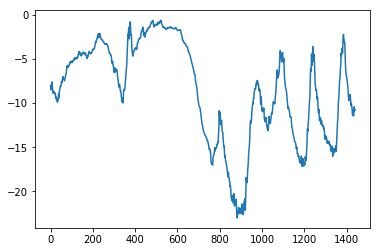

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

## Preparing the data


We will use the following parameter values:

* `lookback = 720`, i.e. our observations will go back 5 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. We will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. 
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

---

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try 
simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally 
expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate 
and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of 
activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

print('tf version', tf.__version__)

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=2,
                              validation_data=val_gen,
                              validation_steps=val_steps)

tf version 2.0.0-beta0
Epoch 1/2
500/500 [==============================] - 15s 30ms/step - loss: 1.1935 - val_loss: 0.5470
Epoch 2/2
499/500 [============================>.] - ETA: 0s - loss: 0.4207

E0613 03:47:20.628796 140735531586432 ultratb.py:149] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-20bf82777556>", line 19, in <module>
    validation_steps=val_steps)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1176, in fit_generator
    steps_name='steps_per_epoch')
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_generator.py", line 322, in model_iteration
    steps_name='validation_steps')
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_generator.py", line 220, in model_iteration
    batch_data = _get_next_batch(generator, mode)
  File "/Library/Frameworks/Python.framework/Versions/3

KeyboardInterrupt: 

Let's display the loss curves for validation and training:

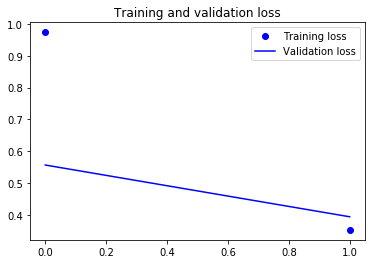

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=1,
                              validation_data=val_gen,
                              validation_steps=val_steps)

500/500 [==============================] - 152s 303ms/step - loss: 0.3043 - val_loss: 0.2762


Let look at our results:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as 
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=1,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.